In [74]:
%load_ext autoreload
%autoreload 2

import gym

import os
import fmuSimulation.gymFMU as ExampleFMU
from fmuSimulation.configReader import configReader
import numpy as np
import sys
import random
import matplotlib.pyplot as plt

import numpy as np
import torch
import os
import utils
import TD3
import TD3Simple



# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
	eval_env = gym.make(env_name)
	eval_env.seed(seed + 100)

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _ = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
max_action = 1e6

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005,
}

max_timesteps = int(1e6)
start_timesteps = int(25e3)
expl_noise = 0.01
max_episode_steps = 1e10
batch_size = 64
eval_freq = 2

policy_noise = 0.02
noise_clip = 0.5
policy_freq = 2
# Target policy smoothing is scaled wrt the action scale

kwargs["policy_noise"] = policy_noise * max_action
kwargs["noise_clip"] = noise_clip * max_action
kwargs["policy_freq"] = policy_freq

#evaluations = [eval_policy(policy, args.env, args.seed)]

In [ ]:
policy = TD3.TD3(**kwargs)

replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

max_timesteps = int(1e5)
for t in range(int(max_timesteps)):
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)
   

    # Perform action
    next_state, reward, done, _ = env.step(action) 
    done_bool = float(done) if episode_timesteps < max_episode_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        print(policy.actor.l3.weight)
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    #if (t + 1) % eval_freq == 0:

        #evaluations.append(eval_policy(policy, args.env, args.seed))
        #np.save(f"./results/{file_name}", evaluations)
        #if args.save_model: policy.save(f"./models/{file_name}")

In [131]:
policy = TD3Simple.TD3(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
config = os.path.abspath('Example.cfg')
cfg = configReader(config)
config = cfg.getAgent()
env = ExampleFMU.gymFMU(config['env_config'])

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
out = np.array([])
height = np.array([])
weights = np.array([])
out = np.append(out, [*state, 0, 0, float(done)])

with torch.no_grad():
    #policy.actor.l3.weight[0][0] = 2
    #policy.actor.l3.weight[0][1] = 0.1
    policy.actor.weight[0] = 2
    policy.actor.weight[1] = 0.001

start_timesteps = 500


Incompatible sample time and stop time.
 Using 5.0 as stop time instead


In [132]:
state, done = env.reset(), False
num_episodes = 1000
max_timesteps = env.fmu.stopTime / env.fmu.dt * num_episodes
start_timesteps = 20e3
start_timesteps = 0
for t in range(int(max_timesteps)):
    if t < env.fmu.stopTime / env.fmu.dt * 100:
        eps = 0.1
    else:
        eps = 0.01


    episode_timesteps += 1

    # Select action randomly or according to policy
    # if (t < start_timesteps):
    if (t < start_timesteps):
        #action = env.action_space.sample()
        action = np.array([np.random.uniform(low=-200, high=200)])
    else:
        action = (
            policy.select_action(np.array(state))
            + np.array([np.random.uniform(low=-2, high=2)])
        ).clip(-max_action, max_action)

    # Select action randomly or according to policy
    #if random.random() < eps:
        #action = env.action_space.sample()
    #else:
        #action = (
            #policy.select_action(np.array(state))
        #).clip(-max_action, max_action)
    

    # Perform action
    next_state, reward, done, _ = env.step(action) 
    out = np.append(out, [*next_state, *action, reward, float(done)])
    done_bool = float(done) if episode_timesteps < max_episode_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)
    
    state = next_state
    episode_reward += reward
    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)
        #pass

    if done:
        height = np.append(height,env.outputs[:,0]) 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        print(policy.actor.weight)
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 
        #weights = np.append(weights, [policy.actor.l3.weight[0][0].cpu().detach().numpy(), policy.actor.l3.weight[0][1].cpu().detach().numpy(), episode_reward])
        weights = np.append(weights, [policy.actor.weight[0].cpu().detach().numpy(), policy.actor.weight[1].cpu().detach().numpy(), episode_reward])

    # Evaluate episode
    #if (t + 1) % eval_freq == 0:

        #evaluations.append(eval_policy(policy, args.env, args.seed))
        #np.save(f"./results/{file_name}", evaluations)
        #if args.save_model: policy.save(f"./models/{file_name}")
out = out.reshape([-1,5])
weights = weights.reshape([-1, 3])

Episode Num: 1 Episode T: 100 Reward: -2121.337
Parameter containing:
tensor([[1.9600e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 2 Episode T: 100 Reward: -2052.352
Parameter containing:
tensor([[1.9199e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)


/home/robert/git/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Episode Num: 3 Episode T: 100 Reward: -2085.455
Parameter containing:
tensor([[1.8799e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 4 Episode T: 100 Reward: -2298.083
Parameter containing:
tensor([[1.8399e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 5 Episode T: 100 Reward: -2162.782
Parameter containing:
tensor([[1.7999e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 6 Episode T: 100 Reward: -2464.657
Parameter containing:
tensor([[1.7599e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 7 Episode T: 100 Reward: -2214.482
Parameter containing:
tensor([[1.7199e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 8 Episode T: 100 Reward: -2357.400
Parameter containing:
tensor([[1.6799e+00],
        [1.0000e-12]], device='cuda:0', requires_grad=True)
Episode Num: 9 Episode T: 100 Reward: -2543.617
Parameter containing:
tensor([[1.6399],


KeyboardInterrupt: 

In [ ]:
state, done = env.reset(), False

num_episodes = 1000
max_timesteps = env.fmu.stopTime / env.fmu.dt * num_episodes
for t in range(int(max_timesteps)):

    i = 0

    episode_timesteps += 1

    # Select action randomly or according to policy
    #if (t < start_timesteps):
        #action = env.action_space.sample()
    if False:
        pass
    else:
        action = (
            policy.select_action(np.array(state))
            #+ np.random.normal(0, i * max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)
    

    # Perform action
    next_state, reward, done, _ = env.step(action) 
    out = np.append(out, [*next_state, *action, reward, float(done)])
    done_bool = float(done) if episode_timesteps < max_episode_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)
        #pass

    if done:
        height = np.append(height,env.outputs[:,0]) 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        print(policy.actor.l3.weight)
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    #if (t + 1) % eval_freq == 0:

        #evaluations.append(eval_policy(policy, args.env, args.seed))
        #np.save(f"./results/{file_name}", evaluations)
        #if args.save_model: policy.save(f"./models/{file_name}")
out = out.reshape([-1,5])
weights = weights.reshape([-1, 3])

In [133]:
out = out.reshape([-1, 5])
weights = weights.reshape([-1, 3])

Parameter containing:
tensor([[26.0745,  4.2821]], device='cuda:0', requires_grad=True)


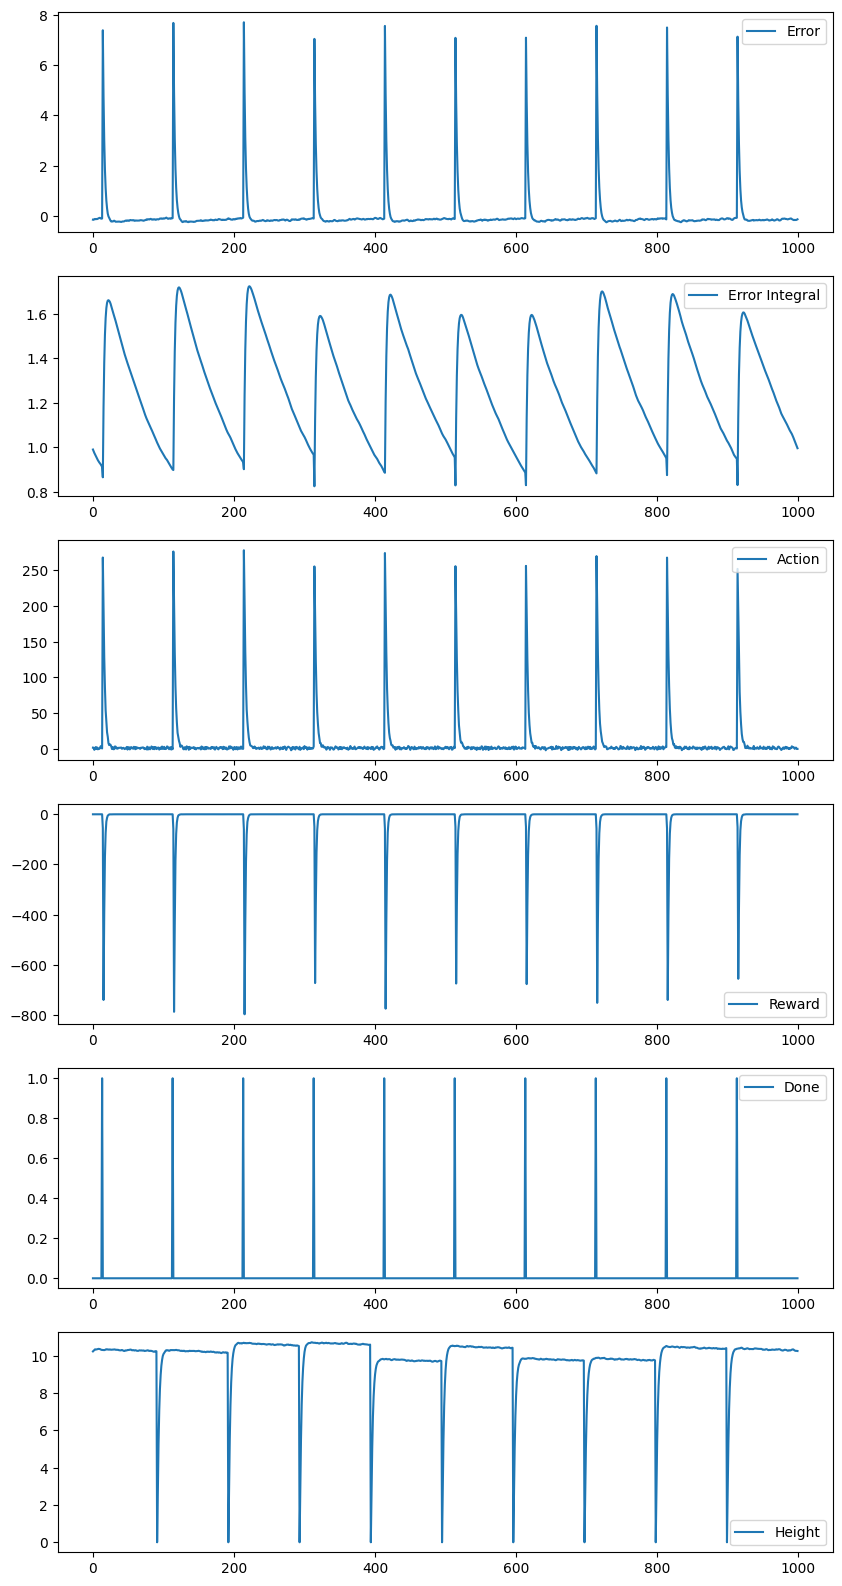

In [87]:
print(policy.actor.l3.weight)
fig = plt.figure(figsize=[10,20])
ax = fig.subplots(6)
start = - 1000 
ax[0].plot(out[start:,0], label='Error')
ax[1].plot(out[start:,1], label='Error Integral')
ax[2].plot(out[start:,2], label='Action')
ax[3].plot(out[start:,3], label='Reward')
ax[4].plot(out[start:,4], label='Done')
ax[5].plot(height[start:], label='Height')
#ax[5].plot(env.outputs[:,0], label='Height')
for axis in ax:
    axis.legend()

#print(1*np.sum(np.square(out[start:,0])))
#print(0.01*np.sum(np.square(out[start:,2])))



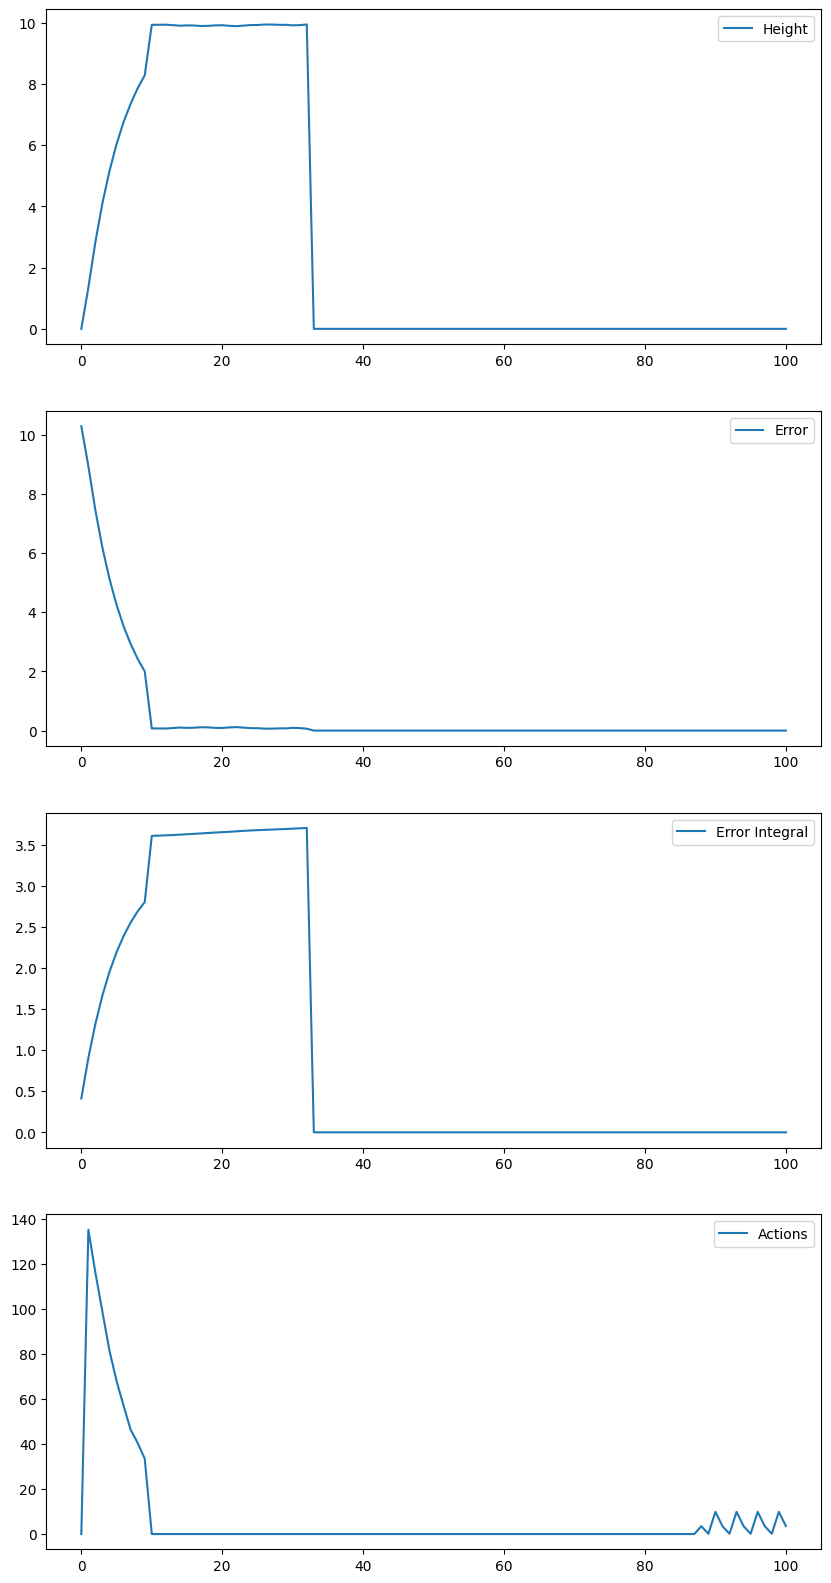

In [134]:
fig = plt.figure(figsize=[10,20])
ax = fig.subplots(4)

ax[0].plot(env.outputs[:,0], label='Height')
ax[1].plot(env.outputs[:,1], label='Error')
ax[2].plot(env.outputs[:,2], label='Error Integral')
ax[3].plot(env.inputs[:,0], label='Actions')

#ax[5].plot(env.outputs[:,0], label='Height')
for axis in ax:
    axis.legend()


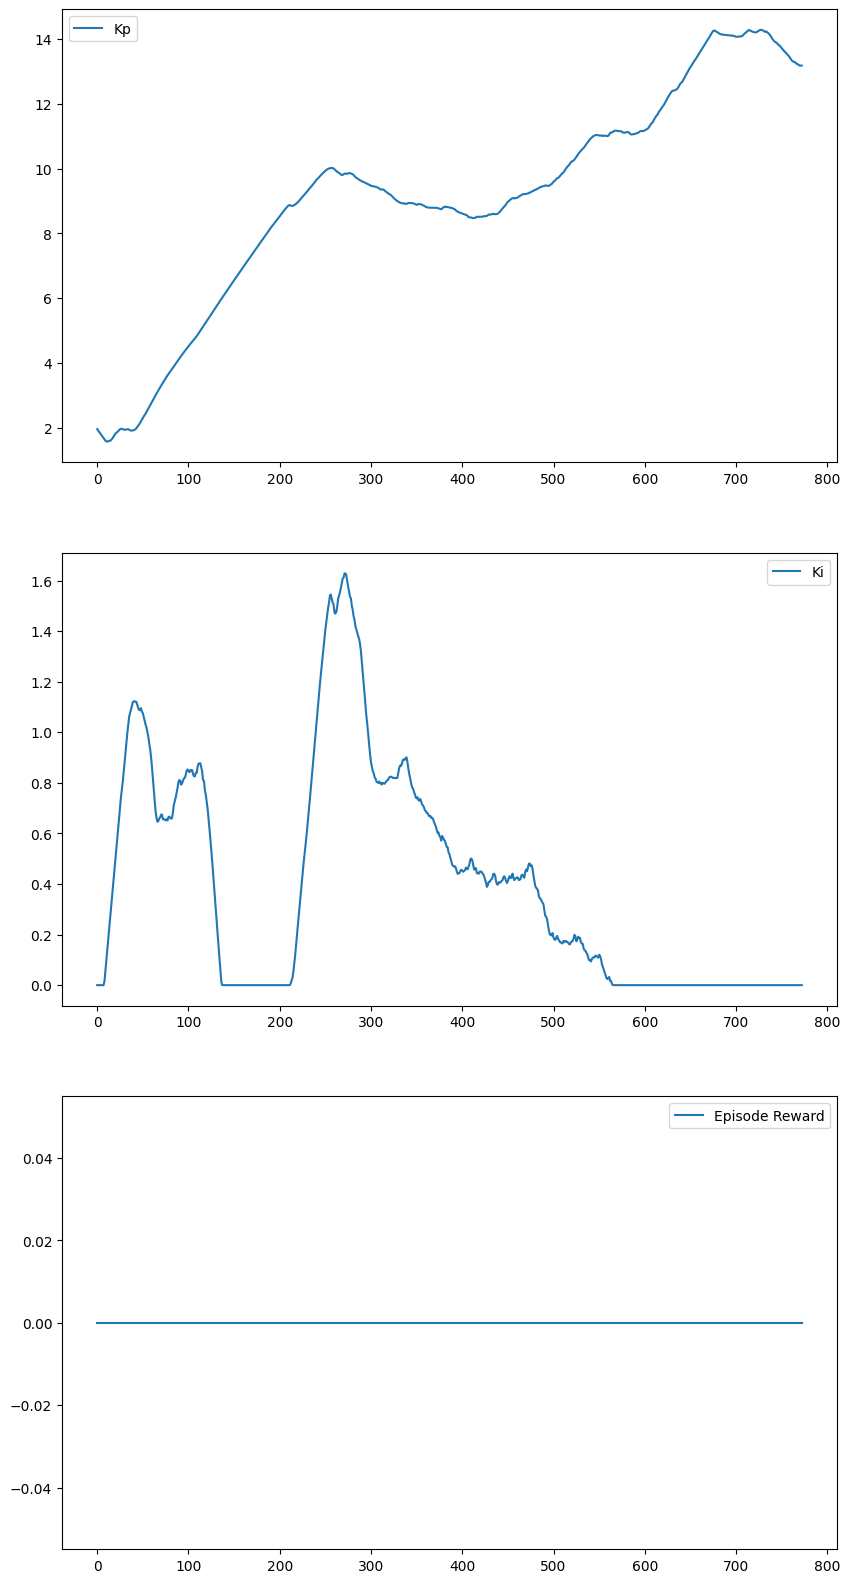

In [145]:
fig = plt.figure(figsize=[10,20])
ax = fig.subplots(3)
labels = ['Kp', 'Ki', 'Episode Reward']
for i, axis in enumerate(ax):
    axis.plot(weights[:,i], label=labels[i])
    axis.legend()

#ax[2].plot(out[:,3])

In [139]:
import pickle
with open('output.pkl', 'wb') as f:
    pickle.dump([weights, out], f)

Parameter containing:
tensor([[-0.0073,  0.2126]], requires_grad=True)

In [144]:
import fmuSimulation.plot as ltxplt
fig, ax = ltxplt.subplots()

array([array([8.472218], dtype=float32), array([0.47468], dtype=float32),
       0], dtype=object)

In [118]:
torch.matmul(torch.tensor([1.,1.], l1.weight))

TypeError: tensor() takes 1 positional argument but 2 were given

In [122]:
t = torch.tensor([1.,1.])
t * l1

TypeError: unsupported operand type(s) for *: 'Tensor' and 'Linear'